[(2524.1591, 1855.3702), (2350.4573, 1230.4712), (2597.4297, 1511.4885), (2781.4578, 1358.5997), (2931.032, 1968.4543)]
1.0128835875066737


1.0540254802268043


1.105326768274582


1.055387333193218


1.0732658626665779


1.1327834118437914


1.073431468327724


1.0394733322001084


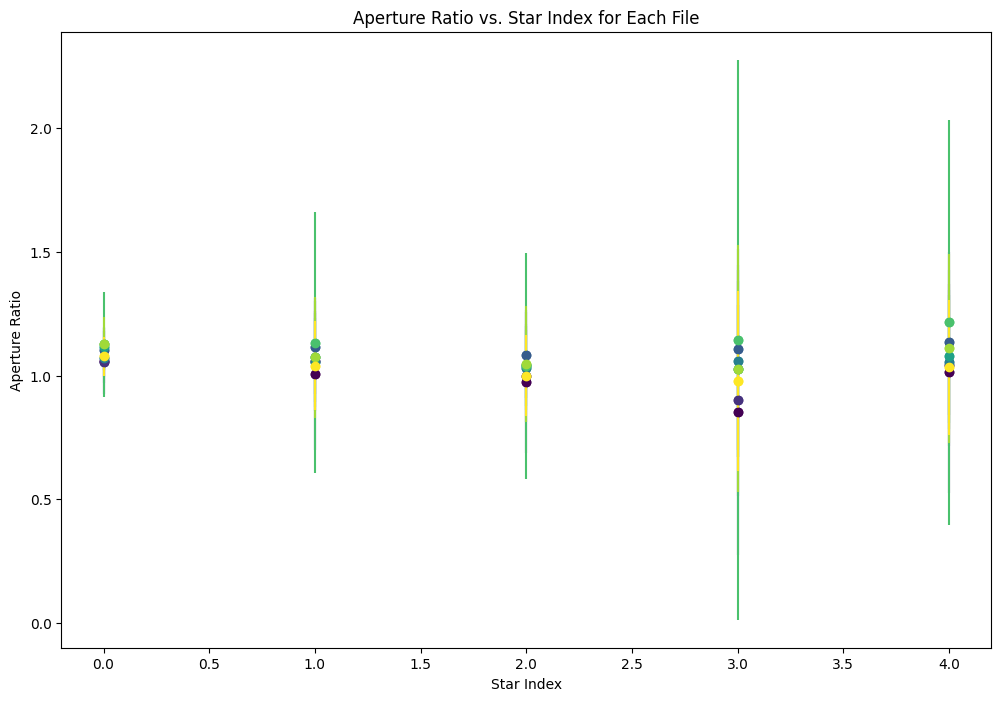

In [23]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import matplotlib.cm as cm
import glob
from astropy.time import Time

file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/i/'

# Change to the directory containing the images
os.chdir(file_dir)
image_files = glob.glob('*.fts')

# Define the list of star coordinates 
star_list = [(2524.1591, 1855.3702), (2350.4573, 1230.4712), (2597.4297, 1511.4885), (2781.4578, 1358.5997),(2931.032, 1968.4543)]

vv_pup = SkyCoord.from_name('VV Pup')
ra = vv_pup.ra.deg
dec = vv_pup.dec.deg

data = fits.getdata('/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/g/maw_VV_Pup_g_240s_2025-02-21T04-21-00.fts')
header = fits.getheader('/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/g/maw_VV_Pup_g_240s_2025-02-21T04-21-00.fts')


egain = header['EGAIN']
gain = 4*egain
rdnoise = 6.7    
#gain = 1

wcs = WCS(header)
xst, yst = wcs.all_world2pix(ra, dec,0)
xst = float(xst)
yst = float(yst)
star_list = star_list
print(star_list)

star_list_ra_dec = []
for x, y in star_list:
    ra, dec = wcs.all_pix2world(x, y, 0)
    star_list_ra_dec.append((ra, dec))

# Initialize a list to store results for all files
all_results = []

# Loop over each image file
for image_file in image_files:
    # Load the FITS data
    data = fits.getdata(image_file)
    header = fits.getheader(image_file)
    wcs = WCS(header)
    star_list = []
    for ra, dec in star_list_ra_dec:
        x, y = wcs.all_world2pix(ra, dec, 0)
        star_list.append((x, y))
        np.array(star_list)
    

    exptime = header['EXPTIME']
    exptimedays = exptime/(24*3600)
    addjd = exptimedays/2
    
    # Define the aperture and annulus parameters
    aperture_radius = 8  # Radius of the aperture
    annulus_inner_radius = 22  # Inner radius of the annulus
    annulus_outer_radius = 30  # Outer radius of the annulus

    # Calculate the mean, median, and standard deviation of the data
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    
    sigclip = SigmaClip(sigma=3., maxiters=10)
    
    # Initialize a dictionary to store the results for this file
    ut_date = header['DATE-OBS'] 

    # Create an Astropy Time object
    t = Time(ut_date, scale='utc')

    # Get the Julian Date
    jd = t.jd


    # Initialize a dictionary to store the results for this file
    file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}
    
    # Perform aperture photometry for each star
    for i, (x, y) in enumerate(star_list):
        ap = CircularAperture((x, y), r=aperture_radius)
        an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
        ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
    
        x, y = ap_stats.centroid
        #print(x, y)
    
        aperture = CircularAperture((x, y), r=aperture_radius)
        annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        
        # Perform aperture photometry
        phot_table = aperture_photometry(data, aperture)
        bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
        
        # Calculate the background in the annulus
        bkg_mean = bkgstats.mean
        bkg_sum = bkg_mean * aperture.area

        
        # Subtract the background from the aperture photometry
        source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

        # Error calculation (Poisson noise + background noise)
        error = np.sqrt(phot_table['aperture_sum'][0]*gain + (annulus_aperture.area/aperture.area)**2*bkg_sum*gain + aperture.area*rdnoise**2)
        #error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

        # Turn into a magnitude
        source_mag = -2.5 * np.log10(source_sum / exptime)
        source_mag_err = 1.0857 * error / source_sum
        
        # Store the results with dynamic column names
        file_results[f'star_{i}_x'] = x
        file_results[f'star_{i}_y'] = y
        file_results[f'star_{i}_flux'] = source_sum
        file_results[f'star_{i}_error'] = error
        file_results[f'star_{i}_background'] = bkg_sum

    aperture_radius = 20  # Radius of the aperture
    annulus_inner_radius = 28  # Inner radius of the annulus
    annulus_outer_radius = 35  # Outer radius of the annulus

    # Perform aperture photometry for each star with large apertures
    for i, (x, y) in enumerate(star_list):

        ap = CircularAperture((x, y), r=8)
        an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
        ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
    
        x, y = ap_stats.centroid

        aperture = CircularAperture((x, y), r=aperture_radius)
        # Perform aperture photometry
        phot_table = aperture_photometry(data, aperture)
        bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
        
        # Calculate the background in the annulus
        bkg_mean = bkgstats.mean
        bkg_sum = bkg_mean * aperture.area

        
        # Subtract the background from the aperture photometry
        source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

        # Error calculation (Poisson noise + background noise)
        #error = np.sqrt(phot_table['aperture_sum'][0] + (annulus_aperture.area/aperture.area)**2*bkg_sum)
        error = np.sqrt(phot_table['aperture_sum'][0]*gain + (annulus_aperture.area/aperture.area)**2*bkg_sum*gain + aperture.area*rdnoise**2)
        # Turn into a magnitude
        source_mag = -2.5 * np.log10(source_sum / exptime)
        source_mag_err = 1.0857 * error / source_sum
        
        # Store the results with dynamic column names
        file_results[f'star_{i}_flux_large'] = source_sum
        file_results[f'star_{i}_error_large'] = error
        file_results[f'star_{i}_background_large'] = bkg_sum

        file_results[f'star_{i}_ApRatio'] = file_results[f'star_{i}_flux_large']/file_results[f'star_{i}_flux'] 
        file_results[f'star_{i}_ApRatio_err'] = np.sqrt((file_results[f'star_{i}_error_large']/file_results[f'star_{i}_flux'])**2 + (file_results[f'star_{i}_error']*file_results[f'star_{i}_flux_large']/file_results[f'star_{i}_flux']**2)**2)
 

    
    file_results[f'median_ApRatio'] = np.median(
    [value for i in range(5) if (value := file_results[f'star_{i}_ApRatio']) >= 1]
)
    all_results.append(file_results)
    print(file_results[f'median_ApRatio'])

     #Write aperture ratio to the header
    header['Scale'] = file_results[f'median_ApRatio']
    # Write the header to the file
    fits.writeto(image_file, data, header, overwrite=True)




# Convert the results to a DataFrame for easy analysis
results_df = pd.DataFrame(all_results)

# Extract unique files
files = results_df['file'].unique()

# Create a color map
colors = cm.viridis(np.linspace(0, 1, len(files)))

# Plotting
plt.figure(figsize=(12, 8))

# Loop through each file and plot
for file_index, file in enumerate(files):
    # Filter results for this file
    file_data = results_df[results_df['file'] == file]
    
    for i in range(6):  # Assuming you have 6 stars (0 to 5)
        star_apratio_key = f'star_{i}_ApRatio'
        
        if star_apratio_key in file_data.columns:
            plt.plot(
                i, 
                file_data[star_apratio_key].values[0], 
                'o', 
                color=colors[file_index], 
                label=f'{file} star_{i}' if file_index == 0 else ""
            )
            plt.errorbar(i, file_data[star_apratio_key].values[0], yerr=file_data[f'star_{i}_ApRatio_err'].values[0], fmt='o', color=colors[file_index])

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(), loc='best')

# Labeling
plt.xlabel('Star Index')
plt.ylabel('Aperture Ratio')
plt.title('Aperture Ratio vs. Star Index for Each File')
plt.grid(False)

# Show plot
plt.show()


# Save the results to a CSV file
results_df.to_csv('/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/i/ap_cor_i.csv', index=False)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


[(394.9332007, 257.2741659), (63.93138124, 515.1233642), (110.6785396, 535.4168557), (159.9685504, 673.0173932), (466.1936032, 792.0117589), (445.18828285665904, 445.13979401738845)]
1.2528802201850415
1.1787300572925843
1.3190755202035311
1.1877984248664397
1.2201961013637812
1.1461993984194148
1.125996096010782
1.120741263462834
1.1699525141187737
1.1321011685717792
1.1373682282011457
star_0_ApRatio
1.2095970743620028
1.1550819758625943
1.289632032959401
1.1761235729933028
1.1910630439954328
1.1254985316477604
1.1131518205677928
1.1109841454750151
1.1479711963675963
1.1293461477247615
1.1214696768220436


star_1_ApRatio
1.2806259294998086
1.1740665069973717
1.3340745906568467
1.1787763643931841
1.2095870022106798
1.1372152000512397
1.1306693398949172
1.120116978084438
1.1868085899385392
1.1320548212689818
1.151279591202869


star_2_ApRatio
1.2852975196124228
1.2136468160060523
1.3419865233528234
1.2353484103723338
1.30590798760098
1.1893185203765415
1.125003621658745
1.12136554884123

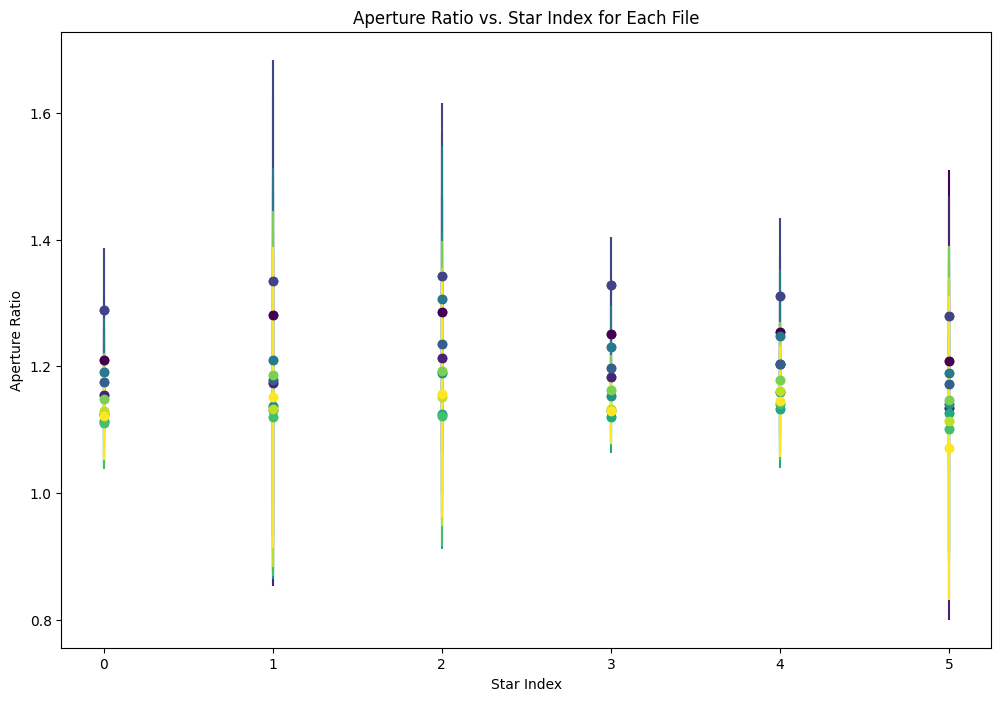

In [15]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import matplotlib.cm as cm

# Change to the directory containing the images
os.chdir('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08')

# Read the list of image files from images.txt
with open('/Users/nathaliehaurberg/Data/SumerMACRO/images_r_nowind.txt', 'r') as f:
    image_files = [line.strip() for line in f if line.strip()]

# Define the list of star coordinates 
star_list = [(394.9332007, 257.2741659), (63.93138124, 515.1233642), (110.6785396, 535.4168557), (159.9685504, 673.0173932), (466.1936032, 792.0117589)]

st_lmi = SkyCoord.from_name('ST LMi')
ra = st_lmi.ra.deg
dec = st_lmi.dec.deg

data = fits.getdata('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08/STLMi_g_60s_2024-05-08T06-00-51_cutout.fits')
header = fits.getheader('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08/STLMi_g_60s_2024-05-08T06-00-51_cutout.fits')

rdnoise = 6.7    

wcs = WCS(header)
xst, yst = wcs.all_world2pix(ra, dec,0)
xst = float(xst)
yst = float(yst)
star_list = star_list + [(xst, yst)]
print(star_list)

# Initialize a list to store results for all files
all_results = []

# Loop over each image file
for image_file in image_files:
    # Load the FITS data
    data = fits.getdata(image_file)
    header = fits.getheader(image_file)

    exptime = header['EXPTIME']
    exptimedays = exptime/(24*3600)
    addjd = exptimedays/2
    
    # Define the aperture and annulus parameters
    aperture_radius = 4  # Radius of the aperture
    annulus_inner_radius = 12  # Inner radius of the annulus
    annulus_outer_radius = 17  # Outer radius of the annulus

    # Calculate the mean, median, and standard deviation of the data
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    
    sigclip = SigmaClip(sigma=3., maxiters=10)
    
    # Initialize a dictionary to store the results for this file
    file_results = {'file': image_file, 'Julian_Date': (header['JD']+addjd)}
    
    # Perform aperture photometry for each star
    for i, (x, y) in enumerate(star_list):
        ap = CircularAperture((x, y), r=aperture_radius)
        an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
        ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
    
        x, y = ap_stats.centroid
        #print(x, y)
    
        aperture = CircularAperture((x, y), r=aperture_radius)
        annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        
        # Perform aperture photometry
        phot_table = aperture_photometry(data, aperture)
        bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
        
        # Calculate the background in the annulus
        bkg_mean = bkgstats.mean
        bkg_sum = bkg_mean * aperture.area
        
        bkg_mean_nopedestal = bkg_mean-1000
        bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

        
        # Subtract the background from the aperture photometry
        source_sum = phot_table['aperture_sum'][0] - bkg_sum

        # Error calculation (Poisson noise + background noise)
        #error = np.sqrt(phot_table['aperture_sum'][0] + (annulus_aperture.area/aperture.area)**2*bkg_sum)
        error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

        # Turn into a magnitude
        source_mag = -2.5 * np.log10(source_sum / 60)
        source_mag_err = 1.0857 * error / source_sum
        
        # Store the results with dynamic column names
        file_results[f'star_{i}_x'] = x
        file_results[f'star_{i}_y'] = y
        file_results[f'star_{i}_flux'] = source_sum
        file_results[f'star_{i}_error'] = error
        file_results[f'star_{i}_background'] = bkg_sum

    aperture_radius = 10  # Radius of the aperture
    annulus_inner_radius = 12  # Inner radius of the annulus
    annulus_outer_radius = 17  # Outer radius of the annulus

    # Perform aperture photometry for each star with large apertures
    for i, (x, y) in enumerate(star_list):

        ap = CircularAperture((x, y), r=4)
        an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
        ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
    
        x, y = ap_stats.centroid

        aperture = CircularAperture((x, y), r=aperture_radius)
        annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        
        # Perform aperture photometry
        phot_table = ApertureStats(data, aperture)
        bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
        
        # Calculate the background in the annulus
        bkg_mean = bkgstats.mean
        bkg_sum = bkg_mean * aperture.area
        
        bkg_mean_nopedestal = bkg_mean-1000
        bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

        
        # Subtract the background from the aperture photometry
        source_sum = phot_table.sum - bkg_sum

        # Error calculation (Poisson noise + background noise)
        #error = np.sqrt(phot_table['aperture_sum'][0] + (annulus_aperture.area/aperture.area)**2*bkg_sum)
        error = np.sqrt((phot_table.sum-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

        # Turn into a magnitude
        source_mag = -2.5 * np.log10(source_sum / exptime)
        source_mag_err = 1.0857 * error / source_sum
        
        # Store the results with dynamic column names
        file_results[f'star_{i}_flux_large'] = source_sum
        file_results[f'star_{i}_error_large'] = error
        file_results[f'star_{i}_background_large'] = bkg_sum

        file_results[f'star_{i}_ApRatio'] = file_results[f'star_{i}_flux_large']/file_results[f'star_{i}_flux'] 
        file_results[f'star_{i}_ApRatio_err'] = np.sqrt((file_results[f'star_{i}_error_large']/file_results[f'star_{i}_flux'])**2 + (file_results[f'star_{i}_error']*file_results[f'star_{i}_flux_large']/file_results[f'star_{i}_flux']**2)**2)
 


    file_results[f'median_ApRatio'] = np.median([file_results[f'star_{i}_ApRatio'] for i in range(6)])
    all_results.append(file_results)
    print(file_results[f'median_ApRatio'])

     #Write aperture ratio to the header
    header['Scale'] = file_results[f'median_ApRatio']
    # Write the header to the file
    fits.writeto(image_file, data, header, overwrite=True)


#print the aperture ratios
for i in range(5):
    print(f'star_{i}_ApRatio')
    for result in all_results:
        print(result[f'star_{i}_ApRatio'])
    print('\n')

# Convert the results to a DataFrame for easy analysis
results_df = pd.DataFrame(all_results)

# Extract unique files
files = results_df['file'].unique()

# Create a color map
colors = cm.viridis(np.linspace(0, 1, len(files)))

# Plotting
plt.figure(figsize=(12, 8))

# Loop through each file and plot
for file_index, file in enumerate(files):
    # Filter results for this file
    file_data = results_df[results_df['file'] == file]
    
    for i in range(6):  # Assuming you have 6 stars (0 to 5)
        star_apratio_key = f'star_{i}_ApRatio'
        
        if star_apratio_key in file_data.columns:
            plt.plot(
                i, 
                file_data[star_apratio_key].values[0], 
                'o', 
                color=colors[file_index], 
                label=f'{file} star_{i}' if file_index == 0 else ""
            )
            plt.errorbar(i, file_data[star_apratio_key].values[0], yerr=file_data[f'star_{i}_ApRatio_err'].values[0], fmt='o', color=colors[file_index])

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(), loc='best')

# Labeling
plt.xlabel('Star Index')
plt.ylabel('Aperture Ratio')
plt.title('Aperture Ratio vs. Star Index for Each File')
plt.grid(False)

# Show plot
plt.show()


# Save the results to a CSV file
results_df.to_csv('/Users/nathaliehaurberg/Data/SumerMACRO/aperture_comp_results_r.csv', index=False)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


[(394.9332007, 257.2741659), (63.93138124, 515.1233642), (110.6785396, 535.4168557), (159.9685504, 673.0173932), (466.1936032, 792.0117589), (445.18828285665904, 445.13979401738845)]
1.2674089774248625
1.2071225925890299
1.2236192980801093
1.1941317377772687
1.1452775025102628
1.1353032144583899
1.1356859686613818
1.16210576442829
1.1233411410621728
1.1163715111220012
1.1188158906187797
1.271081934353865
star_0_ApRatio
1.2337821866775696
1.2337821866775696
1.1970920526343045
1.1970920526343045
1.1970373965357746
1.1970373965357746
1.1755671819935565
1.1755671819935565
1.1301464383336433
1.1301464383336433
1.115075798539736
1.115075798539736
1.1185907943965199
1.1185907943965199
1.132760383077908
1.132760383077908
1.1335136165485968
1.1335136165485968
1.104844085617877
1.104844085617877
1.111141760268008
1.111141760268008
1.2060208171406082
1.2060208171406082


star_1_ApRatio
1.2409415502772823
1.2409415502772823
1.1840901850862242
1.1840901850862242
1.2214633444529914
1.221463344452991

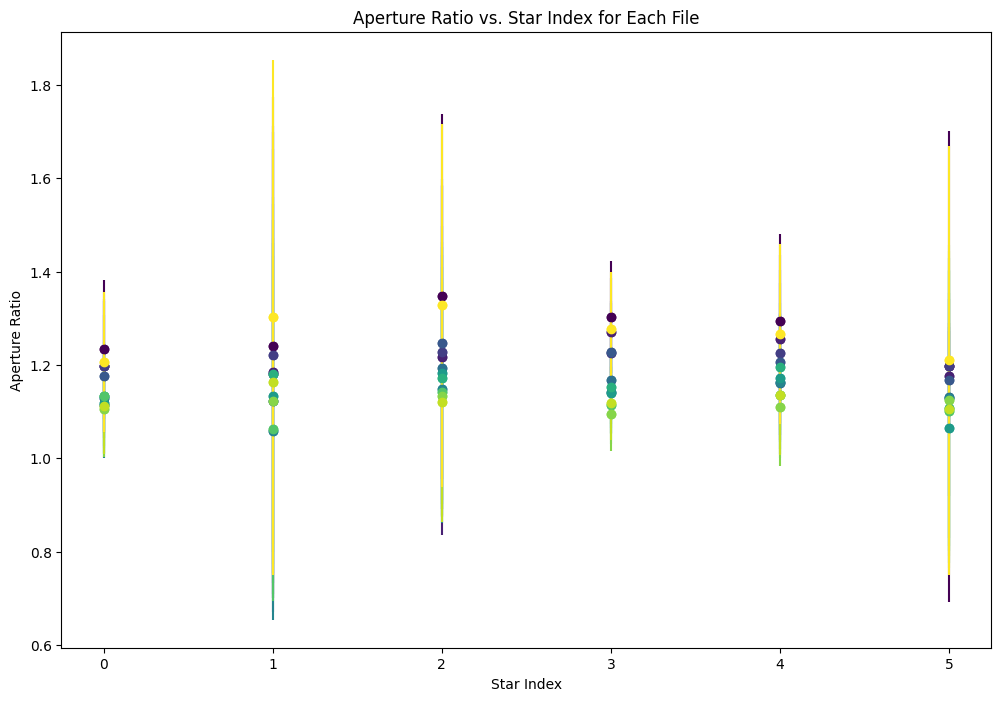

In [130]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import matplotlib.cm as cm

# Change to the directory containing the images
os.chdir('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08')

# Read the list of image files from images.txt
with open('/Users/nathaliehaurberg/Data/SumerMACRO/images_i_nowind.txt', 'r') as f:
    image_files = [line.strip() for line in f if line.strip()]

# Define the list of star coordinates 
star_list = [(394.9332007, 257.2741659), (63.93138124, 515.1233642), (110.6785396, 535.4168557), (159.9685504, 673.0173932), (466.1936032, 792.0117589)]

st_lmi = SkyCoord.from_name('ST LMi')
ra = st_lmi.ra.deg
dec = st_lmi.dec.deg

data = fits.getdata('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08/STLMi_g_60s_2024-05-08T06-00-51_cutout.fits')
header = fits.getheader('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08/STLMi_g_60s_2024-05-08T06-00-51_cutout.fits')

rdnoise = 6.7    

wcs = WCS(header)
xst, yst = wcs.all_world2pix(ra, dec,0)
xst = float(xst)
yst = float(yst)
star_list = star_list + [(xst, yst)]
print(star_list)

# Initialize a list to store results for all files
all_results = []

# Loop over each image file
for image_file in image_files:
    # Load the FITS data
    data = fits.getdata(image_file)
    header = fits.getheader(image_file)

    exptime = header['EXPTIME']
    exptimedays = exptime/(24*3600)
    addjd = exptimedays/2
    
    # Define the aperture and annulus parameters
    aperture_radius = 4  # Radius of the aperture
    annulus_inner_radius = 10  # Inner radius of the annulus
    annulus_outer_radius = 15  # Outer radius of the annulus

    # Calculate the mean, median, and standard deviation of the data
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    
    sigclip = SigmaClip(sigma=3., maxiters=10)
    
    # Initialize a dictionary to store the results for this file
    file_results = {'file': image_file, 'Julian_Date': (header['JD']+addjd)}
    
    # Perform aperture photometry for each star
    for i, (x, y) in enumerate(star_list):
        ap = CircularAperture((x, y), r=aperture_radius)
        an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
        ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
    
        x, y = ap_stats.centroid
        #print(x, y)
    
        aperture = CircularAperture((x, y), r=aperture_radius)
        annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        
        # Perform aperture photometry
        phot_table = aperture_photometry(data, aperture)
        bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
        
        # Calculate the background in the annulus
        bkg_mean = bkgstats.mean
        bkg_sum = bkg_mean * aperture.area
        
        bkg_mean_nopedestal = bkg_mean-1000
        bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

        
        # Subtract the background from the aperture photometry
        source_sum = phot_table['aperture_sum'][0] - bkg_sum

        # Error calculation (Poisson noise + background noise)
        #error = np.sqrt(phot_table['aperture_sum'][0] + (annulus_aperture.area/aperture.area)**2*bkg_sum)
        error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

        # Turn into a magnitude
        source_mag = -2.5 * np.log10(source_sum / 60)
        source_mag_err = 1.0857 * error / source_sum
        
        # Store the results with dynamic column names
        file_results[f'star_{i}_x'] = x
        file_results[f'star_{i}_y'] = y
        file_results[f'star_{i}_flux'] = source_sum
        file_results[f'star_{i}_error'] = error
        file_results[f'star_{i}_background'] = bkg_sum

    aperture_radius = 9  # Radius of the aperture
    annulus_inner_radius = 10  # Inner radius of the annulus
    annulus_outer_radius = 15  # Outer radius of the annulus

    # Perform aperture photometry for each star with large apertures
    for i, (x, y) in enumerate(star_list):

        ap = CircularAperture((x, y), r=4)
        an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
        ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
    
        x, y = ap_stats.centroid

        aperture = CircularAperture((x, y), r=aperture_radius)
        annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        
        # Perform aperture photometry
        phot_table = ApertureStats(data, aperture)
        bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
        
        # Calculate the background in the annulus
        bkg_mean = bkgstats.mean
        bkg_sum = bkg_mean * aperture.area
        
        bkg_mean_nopedestal = bkg_mean-1000
        bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

        
        # Subtract the background from the aperture photometry
        source_sum = phot_table.sum - bkg_sum

        # Error calculation (Poisson noise + background noise)
        #error = np.sqrt(phot_table['aperture_sum'][0] + (annulus_aperture.area/aperture.area)**2*bkg_sum)
        error = np.sqrt((phot_table.sum-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

        # Turn into a magnitude
        source_mag = -2.5 * np.log10(source_sum / exptime)
        source_mag_err = 1.0857 * error / source_sum
        
        # Store the results with dynamic column names
        file_results[f'star_{i}_flux_large'] = source_sum
        file_results[f'star_{i}_error_large'] = error
        file_results[f'star_{i}_background_large'] = bkg_sum

        file_results[f'star_{i}_ApRatio'] = file_results[f'star_{i}_flux_large']/file_results[f'star_{i}_flux'] 
        file_results[f'star_{i}_ApRatio_err'] = np.sqrt((file_results[f'star_{i}_error_large']/file_results[f'star_{i}_flux'])**2 + (file_results[f'star_{i}_error']*file_results[f'star_{i}_flux_large']/file_results[f'star_{i}_flux']**2)**2)
 


    file_results[f'median_ApRatio'] = np.median([file_results[f'star_{i}_ApRatio'] for i in range(6)])
    all_results.append(file_results)
    print(file_results[f'median_ApRatio'])

     #Write aperture ratio to the header
    header['Scale'] = file_results[f'median_ApRatio']
     # Write the header to the file
    fits.writeto(image_file, data, header, overwrite=True)


    # Append the results for this file to the list of all results
    all_results.append(file_results) 
#print the aperture ratios
for i in range(6):
    print(f'star_{i}_ApRatio')
    for result in all_results:
        print(result[f'star_{i}_ApRatio'])
    print('\n')

# Convert the results to a DataFrame for easy analysis
results_df = pd.DataFrame(all_results)

# Extract unique files
files = results_df['file'].unique()

# Create a color map
colors = cm.viridis(np.linspace(0, 1, len(files)))

# Plotting
plt.figure(figsize=(12, 8))

# Loop through each file and plot
for file_index, file in enumerate(files):
    # Filter results for this file
    file_data = results_df[results_df['file'] == file]
    
    for i in range(6):  # Assuming you have 6 stars (0 to 5)
        star_apratio_key = f'star_{i}_ApRatio'
        
        if star_apratio_key in file_data.columns:
            plt.plot(
                i, 
                file_data[star_apratio_key].values[0], 
                'o', 
                color=colors[file_index], 
                label=f'{file} star_{i}' if file_index == 0 else ""
            )
            plt.errorbar(i, file_data[star_apratio_key].values[0], yerr=file_data[f'star_{i}_ApRatio_err'].values[0], fmt='o', color=colors[file_index])

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(), loc='best')

# Labeling
plt.xlabel('Star Index')
plt.ylabel('Aperture Ratio')
plt.title('Aperture Ratio vs. Star Index for Each File')
plt.grid(False)

# Show plot
plt.show()


# Save the results to a CSV file
results_df.to_csv('/Users/nathaliehaurberg/Data/SumerMACRO/aperture_comp_results_i.csv', index=False)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


[(394.9332007, 257.2741659), (63.93138124, 515.1233642), (110.6785396, 535.4168557), (159.9685504, 673.0173932), (466.1936032, 792.0117589), (445.18828285665904, 445.13979401738845)]
1.3385136774318227
1.5654342420536012
1.5127972398167855
2.256818386912137
1.481293080264368
1.7034196829416393
1.6992608400965534
1.4972866367278526
1.5514576745318687
1.6072524928559846
1.385361959943452
1.3709532805869742
1.4612286674031223
1.2344454418936368
1.1262708717032504
1.5935613157645259
1.6317407274207518
1.4625584948278085
1.459103501687228
1.3487431979232034
1.3386436480111683
star_0_ApRatio
1.3402706518929155
1.3402706518929155
1.6959780894026673
1.6959780894026673
1.5912022068912393
1.5912022068912393
1.984740950465306
1.984740950465306
1.6889091739552142
1.6889091739552142
1.6218365544809648
1.6218365544809648
1.5967979458861328
1.5967979458861328
1.3789267054009977
1.3789267054009977
1.6201465954560286
1.6201465954560286
1.4978108954559664
1.4978108954559664
1.2879331844691413
1.28793318

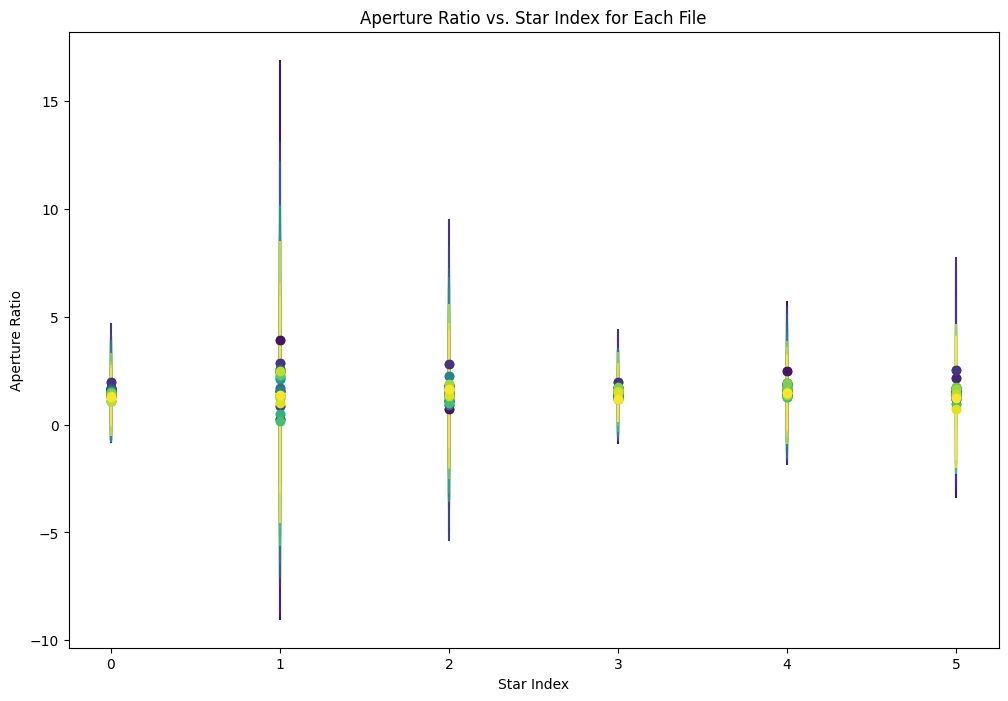

In [131]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import matplotlib.cm as cm

# Change to the directory containing the images
os.chdir('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08')

# Read the list of image files from images.txt
with open('/Users/nathaliehaurberg/Data/SumerMACRO/images_y_nowind.txt', 'r') as f:
    image_files = [line.strip() for line in f if line.strip()]

# Define the list of star coordinates 
star_list = [(394.9332007, 257.2741659), (63.93138124, 515.1233642), (110.6785396, 535.4168557), (159.9685504, 673.0173932), (466.1936032, 792.0117589)]

st_lmi = SkyCoord.from_name('ST LMi')
ra = st_lmi.ra.deg
dec = st_lmi.dec.deg

data = fits.getdata('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08/STLMi_g_60s_2024-05-08T06-00-51_cutout.fits')
header = fits.getheader('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08/STLMi_g_60s_2024-05-08T06-00-51_cutout.fits')

rdnoise = 6.7    

wcs = WCS(header)
xst, yst = wcs.all_world2pix(ra, dec,0)
xst = float(xst)
yst = float(yst)
star_list = star_list + [(xst, yst)]
print(star_list)

# Initialize a list to store results for all files
all_results = []

# Loop over each image file
for image_file in image_files:
    # Load the FITS data
    data = fits.getdata(image_file)
    header = fits.getheader(image_file)

    exptime = header['EXPTIME']
    exptimedays = exptime/(24*3600)
    addjd = exptimedays/2
    
    # Define the aperture and annulus parameters
    aperture_radius = 3  # Radius of the aperture
    annulus_inner_radius = 12  # Inner radius of the annulus
    annulus_outer_radius = 17  # Outer radius of the annulus

    # Calculate the mean, median, and standard deviation of the data
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    
    sigclip = SigmaClip(sigma=3., maxiters=10)
    
    # Initialize a dictionary to store the results for this file
    file_results = {'file': image_file, 'Julian_Date': (header['JD']+addjd)}
    
    # Perform aperture photometry for each star
    for i, (x, y) in enumerate(star_list):
        ap = CircularAperture((x, y), r=aperture_radius)
        an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
        ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
    
        x, y = ap_stats.centroid
        #print(x, y)
    
        aperture = CircularAperture((x, y), r=aperture_radius)
        annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        
        # Perform aperture photometry
        phot_table = aperture_photometry(data, aperture)
        bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
        
        # Calculate the background in the annulus
        bkg_mean = bkgstats.mean
        bkg_sum = bkg_mean * aperture.area
        
        bkg_mean_nopedestal = bkg_mean-1000
        bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

        
        # Subtract the background from the aperture photometry
        source_sum = phot_table['aperture_sum'][0] - bkg_sum

        # Error calculation (Poisson noise + background noise)
        #error = np.sqrt(phot_table['aperture_sum'][0] + (annulus_aperture.area/aperture.area)**2*bkg_sum)
        error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

        # Turn into a magnitude
        source_mag = -2.5 * np.log10(source_sum / 60)
        source_mag_err = 1.0857 * error / source_sum
        
        # Store the results with dynamic column names
        file_results[f'star_{i}_x'] = x
        file_results[f'star_{i}_y'] = y
        file_results[f'star_{i}_flux'] = source_sum
        file_results[f'star_{i}_error'] = error
        file_results[f'star_{i}_background'] = bkg_sum

    aperture_radius = 10  # Radius of the aperture
    annulus_inner_radius = 12  # Inner radius of the annulus
    annulus_outer_radius = 17  # Outer radius of the annulus

    # Perform aperture photometry for each star with large apertures
    for i, (x, y) in enumerate(star_list):

        ap = CircularAperture((x, y), r=4)
        an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
        ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
    
        x, y = ap_stats.centroid

        aperture = CircularAperture((x, y), r=aperture_radius)
        annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        
        # Perform aperture photometry
        phot_table = ApertureStats(data, aperture)
        bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
        
        # Calculate the background in the annulus
        bkg_mean = bkgstats.mean
        bkg_sum = bkg_mean * aperture.area
        
        bkg_mean_nopedestal = bkg_mean-1000
        bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

        
        # Subtract the background from the aperture photometry
        source_sum = phot_table.sum - bkg_sum

        # Error calculation (Poisson noise + background noise)
        #error = np.sqrt(phot_table['aperture_sum'][0] + (annulus_aperture.area/aperture.area)**2*bkg_sum)
        error = np.sqrt((phot_table.sum-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

        # Turn into a magnitude
        source_mag = -2.5 * np.log10(source_sum / exptime)
        source_mag_err = 1.0857 * error / source_sum
        
        # Store the results with dynamic column names
        file_results[f'star_{i}_flux_large'] = source_sum
        file_results[f'star_{i}_error_large'] = error
        file_results[f'star_{i}_background_large'] = bkg_sum

        file_results[f'star_{i}_ApRatio'] = file_results[f'star_{i}_flux_large']/file_results[f'star_{i}_flux'] 
        file_results[f'star_{i}_ApRatio_err'] = np.sqrt((file_results[f'star_{i}_error_large']/file_results[f'star_{i}_flux'])**2 + (file_results[f'star_{i}_error']*file_results[f'star_{i}_flux_large']/file_results[f'star_{i}_flux']**2)**2)
 

    file_results[f'median_ApRatio'] = np.median([file_results[f'star_{i}_ApRatio'] for i in range(6)])
    all_results.append(file_results)
    print(file_results[f'median_ApRatio'])

     #Write aperture ratio to the header
    header['Scale'] = file_results[f'median_ApRatio']
    # Write the header to the file
    fits.writeto(image_file, data, header, overwrite=True)



    # Append the results for this file to the list of all results
    all_results.append(file_results) 
#print the aperture ratios
for i in range(6):
    print(f'star_{i}_ApRatio')
    for result in all_results:
        print(result[f'star_{i}_ApRatio'])
    print('\n')

# Convert the results to a DataFrame for easy analysis
results_df = pd.DataFrame(all_results)

# Extract unique files
files = results_df['file'].unique()

# Create a color map
colors = cm.viridis(np.linspace(0, 1, len(files)))

# Plotting
plt.figure(figsize=(12, 8))

# Loop through each file and plot
for file_index, file in enumerate(files):
    # Filter results for this file
    file_data = results_df[results_df['file'] == file]
    
    for i in range(6):  # Assuming you have 6 stars (0 to 5)
        star_apratio_key = f'star_{i}_ApRatio'
        
        if star_apratio_key in file_data.columns:
            plt.plot(
                i, 
                file_data[star_apratio_key].values[0], 
                'o', 
                color=colors[file_index], 
                label=f'{file} star_{i}' if file_index == 0 else ""
            )
            plt.errorbar(i, file_data[star_apratio_key].values[0], yerr=file_data[f'star_{i}_ApRatio_err'].values[0], fmt='o', color=colors[file_index])

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(), loc='best')

# Labeling
plt.xlabel('Star Index')
plt.ylabel('Aperture Ratio')
plt.title('Aperture Ratio vs. Star Index for Each File')
plt.grid(False)

# Show plot
plt.show()


# Save the results to a CSV file
results_df.to_csv('/Users/nathaliehaurberg/Data/SumerMACRO/aperture_comp_results_y.csv', index=False)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


[(394.9332007, 257.2741659), (63.93138124, 515.1233642), (110.6785396, 535.4168557), (159.9685504, 673.0173932), (466.1936032, 792.0117589), (445.18828285665904, 445.13979401738845)]
1.447072823247881
1.4256590144529995
1.4551467127382898
1.391369510335494
1.2925597636209938
1.3412839629728661
1.3322151210859188
1.3423043655677693
1.2717108390396956
1.2579873588847512
1.195778528451943
1.2349464638213405
1.1864036995847544
1.3487235181913009
1.2990651407755238
1.2546095566356767
1.2240450871400945
1.2660943805641711
1.2089917506458039
1.2034072111346465
star_0_ApRatio
1.3450365805589068
1.3450365805589068
1.2280826151085718
1.2280826151085718
1.3358567632784148
1.3358567632784148
1.2683720969748828
1.2683720969748828
1.2212173648491087
1.2212173648491087
1.1757585292897565
1.1757585292897565
1.2432038576038045
1.2432038576038045
1.2233823263324723
1.2233823263324723
1.195842004295808
1.195842004295808
1.1510353433588048
1.1510353433588048
1.1183515496556338
1.1183515496556338
1.1239632

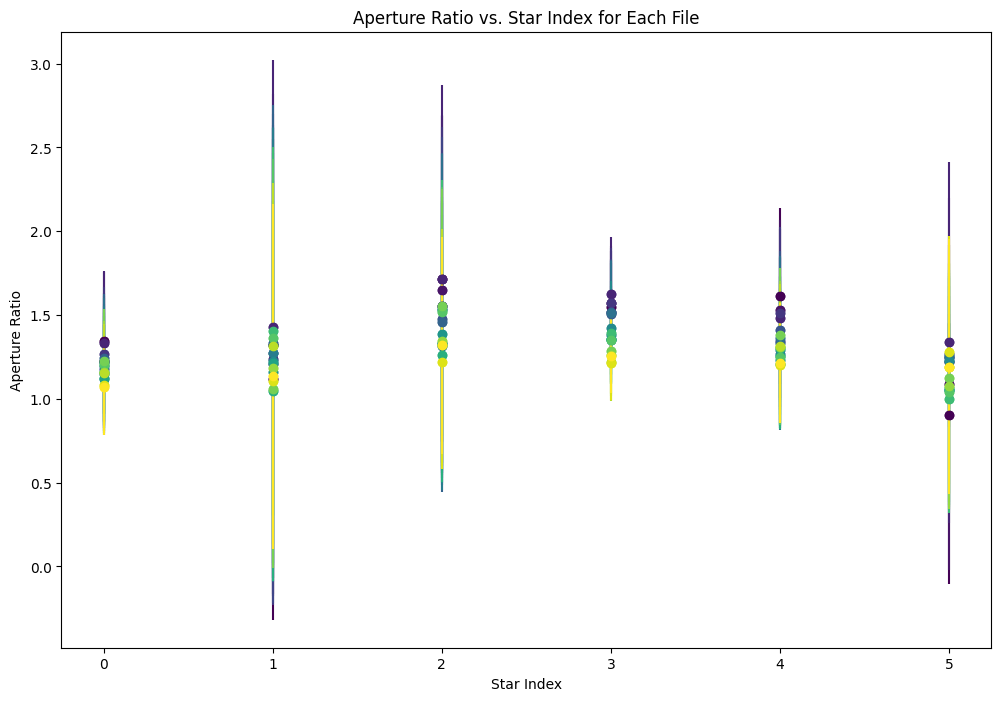

In [132]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import matplotlib.cm as cm

# Change to the directory containing the images
os.chdir('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08')

# Read the list of image files from images.txt
with open('/Users/nathaliehaurberg/Data/SumerMACRO/images_z_nowind.txt', 'r') as f:
    image_files = [line.strip() for line in f if line.strip()]

# Define the list of star coordinates 
star_list = [(394.9332007, 257.2741659), (63.93138124, 515.1233642), (110.6785396, 535.4168557), (159.9685504, 673.0173932), (466.1936032, 792.0117589)]

st_lmi = SkyCoord.from_name('ST LMi')
ra = st_lmi.ra.deg
dec = st_lmi.dec.deg

data = fits.getdata('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08/STLMi_g_60s_2024-05-08T06-00-51_cutout.fits')
header = fits.getheader('/Users/nathaliehaurberg/Data/SumerMACRO/STLMi-2024-05-08/STLMi_g_60s_2024-05-08T06-00-51_cutout.fits')

rdnoise = 6.7    

wcs = WCS(header)
xst, yst = wcs.all_world2pix(ra, dec,0)
xst = float(xst)
yst = float(yst)
star_list = star_list + [(xst, yst)]
print(star_list)

# Initialize a list to store results for all files
all_results = []

# Loop over each image file
for image_file in image_files:
    # Load the FITS data
    data = fits.getdata(image_file)
    header = fits.getheader(image_file)

    exptime = header['EXPTIME']
    exptimedays = exptime/(24*3600)
    addjd = exptimedays/2
    
    # Define the aperture and annulus parameters
    aperture_radius = 3.5  # Radius of the aperture
    annulus_inner_radius = 11  # Inner radius of the annulus
    annulus_outer_radius = 16  # Outer radius of the annulus

    # Calculate the mean, median, and standard deviation of the data
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    
    sigclip = SigmaClip(sigma=3., maxiters=10)
    
    # Initialize a dictionary to store the results for this file
    file_results = {'file': image_file, 'Julian_Date': (header['JD']+addjd)}
    
    # Perform aperture photometry for each star
    for i, (x, y) in enumerate(star_list):
        ap = CircularAperture((x, y), r=aperture_radius)
        an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
        ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
    
        x, y = ap_stats.centroid
        #print(x, y)
    
        aperture = CircularAperture((x, y), r=aperture_radius)
        annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        
        # Perform aperture photometry
        phot_table = aperture_photometry(data, aperture)
        bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
        
        # Calculate the background in the annulus
        bkg_mean = bkgstats.mean
        bkg_sum = bkg_mean * aperture.area
        
        bkg_mean_nopedestal = bkg_mean-1000
        bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

        
        # Subtract the background from the aperture photometry
        source_sum = phot_table['aperture_sum'][0] - bkg_sum

        # Error calculation (Poisson noise + background noise)
        #error = np.sqrt(phot_table['aperture_sum'][0] + (annulus_aperture.area/aperture.area)**2*bkg_sum)
        error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

        # Turn into a magnitude
        source_mag = -2.5 * np.log10(source_sum / 60)
        source_mag_err = 1.0857 * error / source_sum
        
        # Store the results with dynamic column names
        file_results[f'star_{i}_x'] = x
        file_results[f'star_{i}_y'] = y
        file_results[f'star_{i}_flux'] = source_sum
        file_results[f'star_{i}_error'] = error
        file_results[f'star_{i}_background'] = bkg_sum

    aperture_radius = 10  # Radius of the aperture
    annulus_inner_radius = 11  # Inner radius of the annulus
    annulus_outer_radius = 16  # Outer radius of the annulus

    # Perform aperture photometry for each star with large apertures
    for i, (x, y) in enumerate(star_list):

        ap = CircularAperture((x, y), r=4)
        an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
        ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
    
        x, y = ap_stats.centroid

        aperture = CircularAperture((x, y), r=aperture_radius)
        annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
        
        # Perform aperture photometry
        phot_table = ApertureStats(data, aperture)
        bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
        
        # Calculate the background in the annulus
        bkg_mean = bkgstats.mean
        bkg_sum = bkg_mean * aperture.area
        
        bkg_mean_nopedestal = bkg_mean-1000
        bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

        
        # Subtract the background from the aperture photometry
        source_sum = phot_table.sum - bkg_sum

        # Error calculation (Poisson noise + background noise)
        #error = np.sqrt(phot_table['aperture_sum'][0] + (annulus_aperture.area/aperture.area)**2*bkg_sum)
        error = np.sqrt((phot_table.sum-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

        # Turn into a magnitude
        source_mag = -2.5 * np.log10(source_sum / exptime)
        source_mag_err = 1.0857 * error / source_sum
        
        # Store the results with dynamic column names
        file_results[f'star_{i}_flux_large'] = source_sum
        file_results[f'star_{i}_error_large'] = error
        file_results[f'star_{i}_background_large'] = bkg_sum

        file_results[f'star_{i}_ApRatio'] = file_results[f'star_{i}_flux_large']/file_results[f'star_{i}_flux'] 
        file_results[f'star_{i}_ApRatio_err'] = np.sqrt((file_results[f'star_{i}_error_large']/file_results[f'star_{i}_flux'])**2 + (file_results[f'star_{i}_error']*file_results[f'star_{i}_flux_large']/file_results[f'star_{i}_flux']**2)**2)
 


    file_results[f'median_ApRatio'] = np.median([file_results[f'star_{i}_ApRatio'] for i in range(6)])
    all_results.append(file_results)
    print(file_results[f'median_ApRatio'])

     #Write aperture ratio to the header
    header['Scale'] = file_results[f'median_ApRatio']
    # Write the header to the file
    fits.writeto(image_file, data, header, overwrite=True)



    # Append the results for this file to the list of all results
    all_results.append(file_results) 
#print the aperture ratios
for i in range(6):
    print(f'star_{i}_ApRatio')
    for result in all_results:
        print(result[f'star_{i}_ApRatio'])
    print('\n')

# Convert the results to a DataFrame for easy analysis
results_df = pd.DataFrame(all_results)

# Extract unique files
files = results_df['file'].unique()

# Create a color map
colors = cm.viridis(np.linspace(0, 1, len(files)))

# Plotting
plt.figure(figsize=(12, 8))

# Loop through each file and plot
for file_index, file in enumerate(files):
    # Filter results for this file
    file_data = results_df[results_df['file'] == file]
    
    for i in range(6):  # Assuming you have 6 stars (0 to 5)
        star_apratio_key = f'star_{i}_ApRatio'
        
        if star_apratio_key in file_data.columns:
            plt.plot(
                i, 
                file_data[star_apratio_key].values[0], 
                'o', 
                color=colors[file_index], 
                label=f'{file} star_{i}' if file_index == 0 else ""
            )
            plt.errorbar(i, file_data[star_apratio_key].values[0], yerr=file_data[f'star_{i}_ApRatio_err'].values[0], fmt='o', color=colors[file_index])

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(), loc='best')

# Labeling
plt.xlabel('Star Index')
plt.ylabel('Aperture Ratio')
plt.title('Aperture Ratio vs. Star Index for Each File')
plt.grid(False)

# Show plot
plt.show()


# Save the results to a CSV file
results_df.to_csv('/Users/nathaliehaurberg/Data/SumerMACRO/aperture_comp_results_z.csv', index=False)